<a href="https://colab.research.google.com/github/simarpreet0037/agri_finance_dashboard/blob/main/LIF_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W2D3_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [4]:
# @title Plotting Functions

def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])
  plt.show()


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()

In [5]:
# @markdown Execute this code to initialize the default parameters

def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .01   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
print(pars)

{'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.01, 'range_t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 3.9997e+02, 3.9998e+02,
       3.9999e+02])}


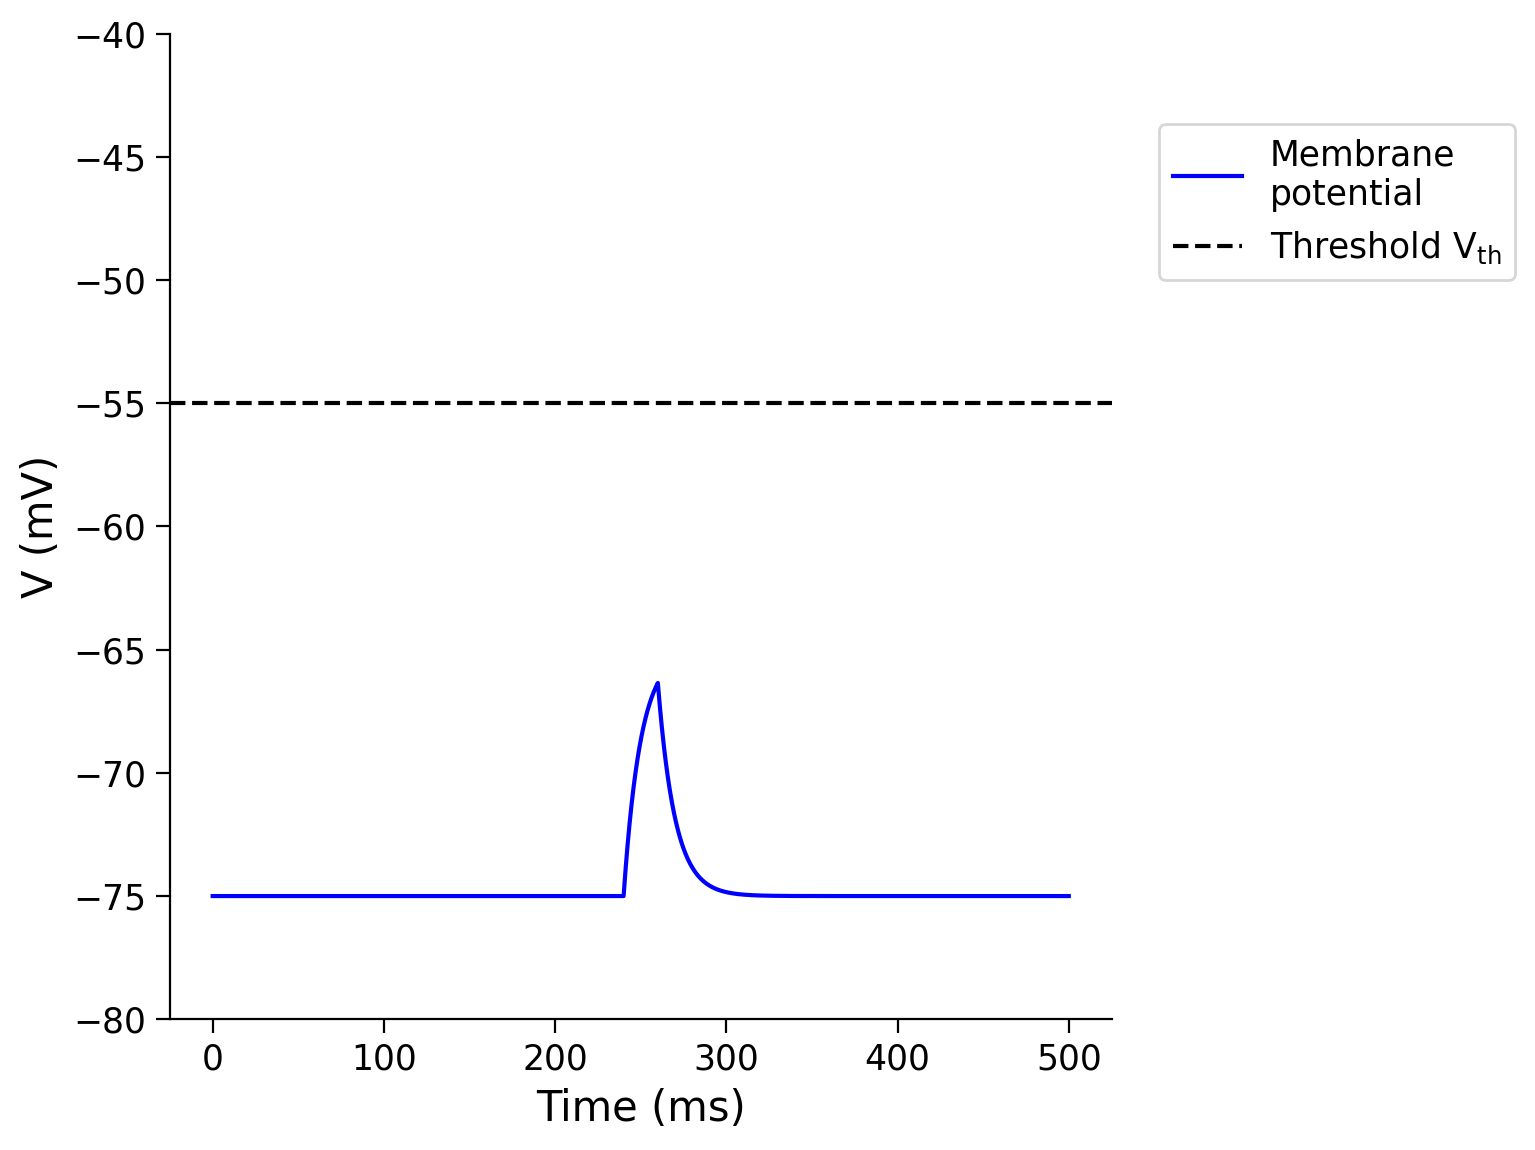

In [6]:
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # If current pulse, set beginning and end to 0
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0

  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration

  for it in range(Lt - 1):

    if tr > 0:  # check if in refractory period
      v[it] = V_reset  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period

    elif v[it] >= V_th:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      v[it] = V_reset  # reset voltage
      tr = tref / dt  # set refractory time

    ########################################################################
    ## TODO for students: compute the membrane potential v, spike train sp #
    # Fill out function and remove
    #raise NotImplementedError('Student Exercise: calculate the dv/dt and the update step!')
    ########################################################################

     # Calculate the change in membrane potential using the LIF equation
    dv = (- (v[it] - E_L) + (Iinj[it] / g_L)) / tau_m  # LIF equation

    # Update the membrane potential using the Euler method
    v[it + 1] = v[it] + dv * dt


  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


# Get parameters
pars = default_pars(T=500)

# Simulate LIF model
v, sp = run_LIF(pars, Iinj=100, stop=True)

# Visualize
plot_volt_trace(pars, v, sp)

In [7]:
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    I_dc=widgets.FloatSlider(50., min=0., max=300., step=10.,
                             layout=my_layout),
    tau_m=widgets.FloatSlider(10., min=2., max=20., step=2.,
                              layout=my_layout)
)

def diff_DC(I_dc=200., tau_m=10.):
  pars = default_pars(T=100.)
  pars['tau_m'] = tau_m
  v, sp = run_LIF(pars, Iinj=I_dc)
  plot_volt_trace(pars, v, sp)
  plt.show()

interactive(children=(FloatSlider(value=50.0, description='I_dc', layout=Layout(width='450px'), max=300.0, ste…